# Milestone 5 (Final)

Berkeley D. Willis  
Class: Data Preparation 540-T303  
Date: 2020-05-26

## 1. Setup the environment

There are multiple things we are going to need for libraries and some basic setup for each datasource from the previous milestones.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import json
import requests
import datetime
from bs4 import BeautifulSoup
import sqlite3

# API Key will be disabled after this project is completed and submitted
API_KEY="3a91d615aae2025a8c553ec5b95ea810"

# This is the name of the db that we are going to be using, and setup the DB
con = sqlite3.connect("movies.db")

## 2. Load project data into environment

Now that we have a DB we are going to source by source load the data into the python environment for preparation.

#### First load and clean the netflix data

In [2]:
# First intial load of the data
netflix_data = pd.read_csv("./data/netflix_titles.csv")

# Now data cleaning operations from previous milestones
if any(netflix_data['show_id'].duplicated()):
    print("Duplicates have been detected in show_id column")

if any(netflix_data['title'].duplicated()):
    print("Duplicates have been detected in title column")

netflix_data = netflix_data.rename(columns={
        "show_id":"netflix_id", "type":"media_type","cast":"netflix_cast","date_added":"netflix_date_str",
        "listed_in":"netflix_categories", "duration":"netflix_duration", "description":"netflix_desc"
    })

# To simplify creating a quick function to sanitize any given string as much as possible for join operations
def sanitize_str(dirty_string):
    # Taking the titles, removing special characters, trimming whitespace, and subbing out for '_' chars
    return(re.sub(' ', '_', re.sub(' +', ' ', re.sub('[^A-Za-z0-9\s]+', '', dirty_string).strip().lower())))

# Going to run it for the titles and for media types
netflix_data['clean_title'] = netflix_data.title.apply(sanitize_str)
# Going to also run it for media_type to make sure that we can handle a movie and show having the same name
netflix_data['clean_media_type'] = netflix_data.media_type.apply(sanitize_str)

# Converting data type to datetime0
netflix_data['netflix_date_added'] = pd.to_datetime(netflix_data.netflix_date_str.str.strip(), format="%B %d, %Y")

# Creating a column for us to be able to identify those that are actually movies
netflix_movie_data = netflix_data[ netflix_data.clean_media_type=="movie" ]

# Reindex for other operations
netflix_movie_data = netflix_movie_data.reset_index(drop=True)

print("We started with {} records, and only have {} movies".format(netflix_data.shape[0],netflix_movie_data.shape[0]))

# Calculating runtime
netflix_movie_data['netflix_timedelta'] = netflix_movie_data.netflix_duration.apply(pd.to_timedelta)

# Quick look at a sample of the data 
display(netflix_movie_data.head())

Duplicates have been detected in title column
We started with 6234 records, and only have 4265 movies


,netflix_id,media_type,title,director,netflix_cast,country,netflix_date_str,release_year,rating,netflix_duration,netflix_categories,netflix_desc,clean_title,clean_media_type,netflix_date_added,netflix_timedelta
0,81145628,Movie,Norm of the North: King Sized Adventure,"Richard Finn, Tim Maltby","Alan Marriott, Andrew Toth, Brian Dobson, Cole...","United States, India, South Korea, China","September 9, 2019",2019,TV-PG,90 min,"Children & Family Movies, Comedies",Before planning an awesome wedding for his gra...,norm_of_the_north_king_sized_adventure,movie,2019-09-09,01:30:00
1,80117401,Movie,Jandino: Whatever it Takes,NaN,Jandino Asporaat,United Kingdom,"September 9, 2016",2016,TV-MA,94 min,Stand-Up Comedy,Jandino Asporaat riffs on the challenges of ra...,jandino_whatever_it_takes,movie,2016-09-09,01:34:00
2,80125979,Movie,#realityhigh,Fernando Lebrija,"Nesta Cooper, Kate Walsh, John Michael Higgins...",United States,"September 8, 2017",2017,TV-14,99 min,Comedies,When nerdy high schooler Dani finally attracts...,realityhigh,movie,2017-09-08,01:39:00
3,70304989,Movie,Automata,Gabe Ibáñez,"Antonio Banderas, Dylan McDermott, Melanie Gri...","Bulgaria, United States, Spain, Canada","September 8, 2017",2014,R,110 min,"International Movies, Sci-Fi & Fantasy, Thrillers","In a dystopian future, an insurance adjuster f...",automata,movie,2017-09-08,01:50:00
4,80164077,Movie,Fabrizio Copano: Solo pienso en mi,"Rodrigo Toro, Francisco Schultz",Fabrizio Copano,Chile,"September 8, 2017",2017,TV-MA,60 min,Stand-Up Comedy,Fabrizio Copano takes audience participation t...,fabrizio_copano_solo_pienso_en_mi,movie,2017-09-08,01:00:00


#### Next the IMDB data

In [3]:
# Helper functions first 

# Take XML and return parsed out dataframe
def parseIMDBData(p_soup):
    titles = []
    runtimes = []
    ratings = []
    genres = []
    imdb_ratings = []
    mcritic_scores = []
    directors = []
    votes = []
    gross = []
    years = []
    for record in p_soup.findAll("div", {"class":"lister-item"}):
        # Append data from each record
        titles.append(record.findAll("a")[1].getText())
        runtimes.append(record.find("span", {"class":"runtime"}).getText())
        # Not always a ratings
        tmp_cert = record.find("span", {"class":"certificate"})
        if tmp_cert != None:
            ratings.append(tmp_cert.getText())
        else:
            ratings.append("")
        genres.append(record.find("span", {"class":"genre"}).getText())
        imdb_ratings.append(record.find("div", {"class":"ratings-imdb-rating"}).find("strong").getText())
        tmp_mcritic = record.find("span", {"class":"metascore"})
        if tmp_mcritic != None:
            mcritic_scores.append(tmp_mcritic.getText())
        else:
            mcritic_scores.append("-1")
        votes.append(record.find("p", {"class":"sort-num_votes-visible"}).findAll("span")[1].getText())
        # Doesn't always have a grossing, else we'll default it
        tmp_gross = record.find("p", {"class":"sort-num_votes-visible"}).findAll("span")
        if len(tmp_gross) > 2:
            gross.append(tmp_gross[4].getText())
        else:
            gross.append("-1")
        years.append(record.find("span",{"class":"lister-item-year"}).getText())
        # Directors are harder to narrow down so this is a very sensitive area and might have issues if the structure
        # of the site changes drastically
        directors.append(record.findAll("p")[2].findAll("a")[0].getText())
    tmp_dict = {"title":titles,"runtime":runtimes,"rating":ratings,"genre":genres,"imdb_score":imdb_ratings,
                "metacritic_score":mcritic_scores,"director":directors,"votes":votes,"gross":gross,"year":years}
    return pd.DataFrame(tmp_dict)

# Cre1ating function to make a request and pull the data from a page
def pullIMDBData():
    # Frist URL that will be requested from
    BASE_URL = "https://www.imdb.com"
    url = BASE_URL + "/search/title/?count=100&groups=top_1000&sort=user_rating"
    # Boolean to tell let know to stop pulling
    MORE_DATA = True
    tmp_list = []
    while MORE_DATA:
        print("Pulling for " + url)
        # Get the response for the current url and parse it immediately
        soup = BeautifulSoup(requests.get(url).content, "html.parser")
        # Let's go ahead and check for and grab the next URL where applicable
        next_obj = soup.findAll("a", {"class": "lister-page-next"})
        if len(next_obj) == 0:
            MORE_DATA = False
        else:
            # Where the next search URL will be found
            url = BASE_URL + next_obj[0].get("href")
        # Now we are going to send the rest to pull the create the dataframe
        tmp_list.append(parseIMDBData(soup))
    # Now just bind them all and return
    return pd.concat(tmp_list, sort=False)

In [4]:
# Now fetch the data and clean it
imdb_movies_df = pullIMDBData()

# Going to re-use the function that was used previously for the same work
def sanitize_str(dirty_string):
    # Taking the titles, removing special characters, trimming whitespace, and subbing out for '_' chars
    return(re.sub(' ', '_', re.sub(' +', ' ', re.sub('[^A-Za-z0-9\s]+', '', dirty_string).strip().lower())))

# Run full sanitization on the tiel field, and run strip o nthe rest of the fields
imdb_movies_df['clean_title'] = imdb_movies_df.title.apply(sanitize_str)

imdb_movies_df['genre'] = imdb_movies_df.genre.apply(str.strip)
imdb_movies_df['rating'] = imdb_movies_df.rating.apply(str.strip)
imdb_movies_df['runtime'] = imdb_movies_df.runtime.apply(str.strip)
imdb_movies_df['imdb_score'] = imdb_movies_df.imdb_score.apply(str.strip)
imdb_movies_df['metacritic_score'] = imdb_movies_df.metacritic_score.apply(str.strip)
imdb_movies_df['director'] = imdb_movies_df.director.apply(str.strip)
imdb_movies_df['votes'] = imdb_movies_df.votes.apply(str.strip)
imdb_movies_df['gross'] = imdb_movies_df.gross.apply(str.strip)
imdb_movies_df['year'] = imdb_movies_df.year.apply(str.strip)

# Convert run time
imdb_movies_df["runtime_num"] = imdb_movies_df.runtime.str.replace(r"\D", "").astype(int)

# Converting imdb_score to float
imdb_movies_df["imdb_score"] = imdb_movies_df.imdb_score.astype(float)

# Now votes
imdb_movies_df["votes"] = imdb_movies_df.votes.str.replace(r"\D", "").astype(int)

# Remove the () marks around the years and convert it to numbers
imdb_movies_df["year"] = imdb_movies_df.year.str.replace(r"\D", "").astype(int)

# Now for gross, but we are going to convert those to raw nubers and then multiply
imdb_movies_df["gross_num"] = imdb_movies_df.gross.str.replace(r"\D", "").astype(int)
imdb_movies_df.loc[ imdb_movies_df.gross.str.contains(pat="M$"), "gross_num"] = imdb_movies_df[ imdb_movies_df.gross.str.contains(pat="M$")]["gross_num"]  * 1000000
# Setting -1 values from default now to Nan
imdb_movies_df.loc[ imdb_movies_df.gross=="-1", "gross_num"] = np.NaN

print("Currently have {} records before de-dup".format(imdb_movies_df.shape[0]))
imdb_movies_df = imdb_movies_df.drop_duplicates(subset=["title","director"])
print("Left with {} records after de-dup".format(imdb_movies_df.shape[0]))

# Gotta add rankings for each one
imdb_movies_df['ranking'] = range(1,imdb_movies_df.shape[0]+1)

imdb_movies_df['top100'] = False
imdb_movies_df.loc[ (imdb_movies_df.ranking<=100) ,'top100'] = True

# I wouldn't surprised if most of these top movies were dramas so we'll also create a new column for it
# Could mine for this during analysis but sometimes these preparation steps can make it easier later
imdb_movies_df['is_drama'] = False
imdb_movies_df['is_crime'] = False
imdb_movies_df.loc[imdb_movies_df.genre.str.contains(pat="Drama"), "is_drama"] = True
imdb_movies_df.loc[imdb_movies_df.genre.str.contains(pat="Crime"), "is_crime"] = True

# Finally we've some of the raw columns that have repatitive and un prepared data, so now I am going to
# limit the number of columns and rename them
final_imdb_movies_df = imdb_movies_df[["ranking","title","director","clean_title","rating","genre","imdb_score",
                                      "metacritic_score","votes","year","runtime_num","gross_num","top100",
                                      "is_drama","is_crime"]]

final_imdb_movies_df.columns = ["imdb_ranking","imdb_title","imdb_director","clean_title","imdb_rating",
                                "imdb_genres","imdb_score","metacritic_score","imdb_votes","imdb_year",
                                "imdb_runtime","imdb_gross","imdb_top100","imdb_drama","imdb_crime"]

# Clean up the dataframes that are no longer needed
del(imdb_movies_df)

# Look at a sample of the data 
display(final_imdb_movies_df.head())

Pulling for https://www.imdb.com/search/title/?count=100&groups=top_1000&sort=user_rating
Pulling for https://www.imdb.com/search/title/?groups=top_1000&sort=user_rating,desc&count=100&start=101
Pulling for https://www.imdb.com/search/title/?groups=top_1000&sort=user_rating,desc&count=100&start=201
Pulling for https://www.imdb.com/search/title/?groups=top_1000&sort=user_rating,desc&count=100&start=301
Pulling for https://www.imdb.com/search/title/?groups=top_1000&sort=user_rating,desc&count=100&start=401
Pulling for https://www.imdb.com/search/title/?groups=top_1000&sort=user_rating,desc&count=100&start=501
Pulling for https://www.imdb.com/search/title/?groups=top_1000&sort=user_rating,desc&count=100&start=601
Pulling for https://www.imdb.com/search/title/?groups=top_1000&sort=user_rating,desc&count=100&start=701
Pulling for https://www.imdb.com/search/title/?groups=top_1000&sort=user_rating,desc&count=100&start=801
Pulling for https://www.imdb.com/search/title/?groups=top_1000&sort=us

,imdb_ranking,imdb_title,imdb_director,clean_title,imdb_rating,imdb_genres,imdb_score,metacritic_score,imdb_votes,imdb_year,imdb_runtime,imdb_gross,imdb_top100,imdb_drama,imdb_crime
0,1,The Shawshank Redemption,Frank Darabont,the_shawshank_redemption,R,Drama,9.3,80,2244831,1994,142,2.834000e+09,True,True,False
1,2,The Godfather,Francis Ford Coppola,the_godfather,R,"Crime, Drama",9.2,100,1548663,1972,175,1.349700e+10,True,True,True
2,3,The Dark Knight,Christopher Nolan,the_dark_knight,PG-13,"Action, Crime, Drama",9.0,84,2213428,2008,152,5.348600e+10,True,True,True
3,4,The Godfather: Part II,Francis Ford Coppola,the_godfather_part_ii,R,"Crime, Drama",9.0,90,1082603,1974,202,5.730000e+09,True,True,True
4,5,The Lord of the Rings: The Return of the King,Peter Jackson,the_lord_of_the_rings_the_return_of_the_king,PG-13,"Adventure, Drama, Fantasy",8.9,94,1586310,2003,201,3.778500e+10,True,True,False


#### Finally load the moviedb.com API data

In [5]:
# Again first helper functions

# Function that will parse a response
def parseResponse(p_json):
    # Set up all the lists that will create the data frame
    popularity_l = []
    ids = []
    video_l = []
    vote_counts = []
    vote_avgs = []
    titles = []
    release_dates = []
    original_langauges = []
    adult_indicators = []
    overviews = []
    
    # For each json object, get the information that is relevant
    for item in p_json['results']:
        popularity_l.append(item['popularity'])
        ids.append(item['id'])
        video_l.append(item['video'])
        vote_counts.append(item['vote_count'])
        vote_avgs.append(item['vote_average'])
        titles.append(item['title'])
        release_dates.append(item['release_date'])
        original_langauges.append(item['original_language'])
        adult_indicators.append(item['adult'])
        overviews.append(item['overview'])
    
    # Then combine them into a single data frame
    tmp_dict = {
        "id":ids,"popularity":popularity_l,"video":video_l,"votes":vote_counts,"vote_average":vote_avgs,
        "title":titles,"release_date":release_dates,"original_langauge":original_langauges,"adult":adult_indicators,
        "overview":overviews
    }
    return pd.DataFrame(tmp_dict)

# Helper to pull a some number of records, but default will be 1000
def downloadMovieData(api_key, num_records=1000):
    # Setup some basic tracking variables 
    current_page = 1
    record_count = 0
    # Base URI that will be used
    API_ENDPOINT = "https://api.themoviedb.org/3/movie/top_rated"
    # Lastly a list to store the resulting dataframes that will be combined later
    pd_list = []
    # Going to repeat until we have 1000 or how ever many records
    while record_count < num_records:
        print("Downloading page {}".format(current_page))
        # Going to make the request and automatically dump its contents into a json object
        json_obj = json.loads(requests.get(API_ENDPOINT+"?api_key="+api_key+"&language=en-US&page="+str(current_page)).content)
        pd_list.append(parseResponse(json_obj))
        record_count += len(json_obj['results'])
        current_page += 1
    return pd.concat(pd_list, sort=False)

In [6]:
# Download the data and then run cleaning operations
moviedb_df = downloadMovieData(API_KEY)

# Attach the ranking
moviedb_df['ranking'] = range(1,moviedb_df.shape[0]+1)

# Create clean version of the title once more
def sanitize_str(dirty_string):
    # Taking the titles, removing special characters, trimming whitespace, and subbing out for '_' chars
    return(re.sub(' ', '_', re.sub(' +', ' ', re.sub('[^A-Za-z0-9\s]+', '', dirty_string).strip().lower())))

# Run full sanitization on the tiel field, and run strip o nthe rest of the fields
moviedb_df['clean_title'] = moviedb_df.title.apply(sanitize_str)

print("Currently have {} records before de-dup".format(moviedb_df.shape[0]))
moviedb_df = moviedb_df.drop_duplicates(subset=["id"])
print("Left with {} records after de-dup".format(moviedb_df.shape[0]))

# Going to assign ranking by popularity and then by number of votes
moviedb_df = moviedb_df.sort_values(by=['popularity'],ascending=False)
moviedb_df['popularity_ranking'] = range(1,moviedb_df.shape[0]+1)

# By vote counts
moviedb_df = moviedb_df.sort_values(by=['votes'],ascending=False)
moviedb_df['vote_count_ranking'] = range(1,moviedb_df.shape[0]+1)

# re-sort and order by ranking given by the db
moviedb_df = moviedb_df.sort_values(by=['ranking'],ascending=False)

print("Data types before conversion")
print(moviedb_df.dtypes)
print("")

# Date field need to converted to a a data type where it being treated as such
moviedb_df['release_date'] = pd.to_datetime(moviedb_df.release_date)

# Should be the same but now pandas is treating it like a number/datetime
print("Data types after conversion")
print(moviedb_df.dtypes)

final_moviesdb_df = moviedb_df[["id","ranking","popularity_ranking","vote_count_ranking","popularity","votes","vote_average",
                                      "title","clean_title","release_date","original_langauge","adult","overview"]]

final_moviesdb_df.columns = ["moviedb_id","moviedb_ranking","moviedb_pop_ranking","movie_dbvote_count_ranking","moviedb_popularity","moviedb_votes","moviedb_vote_average",
                                      "moviedb_title","clean_title","moviedb_release_date","original_langauge","adult","moviedb_overview"]


# Again clean up copy of dataframe and show sample of data
del(moviedb_df)
display(final_moviesdb_df.head())

Currently have 1000 records before de-dup
Left with 1000 records after de-dup
Data types before conversion
id                      int64
popularity            float64
video                    bool
votes                   int64
vote_average          float64
title                  object
release_date           object
original_langauge      object
adult                    bool
overview               object
ranking                 int64
clean_title            object
popularity_ranking      int64
vote_count_ranking      int64
dtype: object

Data types after conversion
id                             int64
popularity                   float64
video                           bool
votes                          int64
vote_average                 float64
title                         object
release_date          datetime64[ns]
original_langauge             object
adult                           bool
overview                      object
ranking                        int64
clean_title            

,moviedb_id,moviedb_ranking,moviedb_pop_ranking,movie_dbvote_count_ranking,moviedb_popularity,moviedb_votes,moviedb_vote_average,moviedb_title,clean_title,moviedb_release_date,original_langauge,adult,moviedb_overview
19,10435,1000,690,638,11.342,560,7.5,Chaplin,chaplin,1992-02-17,en,False,An elderly Charlie Chaplin discusses his autob...
18,10549,999,893,891,9.043,263,7.5,Hamlet,hamlet,1996-12-25,en,False,"Hamlet, Prince of Denmark, returns home to fin..."
17,22584,998,855,904,9.451,255,7.5,To Have and Have Not,to_have_and_have_not,1944-10-11,en,False,A Martinique charter boat skipper gets mixed u...
16,431937,997,964,909,7.241,251,7.5,Mr & Mme Adelman,mr_mme_adelman,2017-03-08,fr,False,How did Sarah and Victor get along for more th...
15,434616,996,975,701,6.819,450,7.5,Patients,patients,2017-03-01,fr,False,After a serious sport accident in a swimming p...


## 3. Merge the data

Now that the data is in the environment, we should merge the datasets and allow them to compliemnt each other in anyways we posssibly can.

In [7]:
# Now we will do full outer merges between teh data sets on the clean titles.
# First the moviedb and imdb data
full_movies_df = final_imdb_movies_df.merge(final_moviesdb_df, on="clean_title", how="outer")
# Then by the netflix data, which had the least number of matches
full_movies_df = full_movies_df.merge(netflix_movie_data, on="clean_title", how="outer")

# Quick look at it but as we can see in the display there are many 
display(full_movies_df.head())

,imdb_ranking,imdb_title,imdb_director,clean_title,imdb_rating,imdb_genres,imdb_score,metacritic_score,imdb_votes,imdb_year,...,country,netflix_date_str,release_year,rating,netflix_duration,netflix_categories,netflix_desc,clean_media_type,netflix_date_added,netflix_timedelta
0,1.0,The Shawshank Redemption,Frank Darabont,the_shawshank_redemption,R,Drama,9.3,80,2244831.0,1994.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT
1,2.0,The Godfather,Francis Ford Coppola,the_godfather,R,"Crime, Drama",9.2,100,1548663.0,1972.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT
2,3.0,The Dark Knight,Christopher Nolan,the_dark_knight,PG-13,"Action, Crime, Drama",9.0,84,2213428.0,2008.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT
3,4.0,The Godfather: Part II,Francis Ford Coppola,the_godfather_part_ii,R,"Crime, Drama",9.0,90,1082603.0,1974.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT
4,5.0,The Lord of the Rings: The Return of the King,Peter Jackson,the_lord_of_the_rings_the_return_of_the_king,PG-13,"Adventure, Drama, Fantasy",8.9,94,1586310.0,2003.0,...,"New Zealand, United States","January 1, 2020",2003.0,PG-13,201 min,"Action & Adventure, Sci-Fi & Fantasy",Aragorn is revealed as the heir to the ancient...,movie,2020-01-01,03:21:00


## 4. Create DB tables and Load data into DB

After the data is merged and cleaned, we should create tables for storage in the DB and load all the records into it. 

In [8]:
# There are two main ways that I can further clean the merged data to where each record has an easily identifiable 
# primary key for the DB, but due to delivery time constraints and other issues where we may do the work to try to
# identify the key, we still may not be able to create one based off our current data. Thus I will simply 
# use a new primary identifier, and essentially just and incremented one

full_movies_df['record_id'] = range(1,full_movies_df.shape[0]+1)

# Wagering pandas, we can easily create a table that can be described by pandas, if it exists already replace it
full_movies_df.to_sql('movies', con=con, if_exists='replace')

/usr/local/lib/python3.6/site-packages/pandas/io/sql.py:450: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  chunksize=chunksize, dtype=dtype)


So everything looks like it made it into the DB, but timedelta couldn't be represented but in an integer which suites our purose fine still.

## 5. Visualizations

Though I am still learning on how to best represent data, we will not we using the matplotlib library in order to visualize data from multiple sources into a few different visualizations.  
However do consider that when doing an analysis on cleaned data for visualization there are data operations that will have to take place.

#### Datasource visualization

First thing I wan to see of the movie records, which were found in which sources

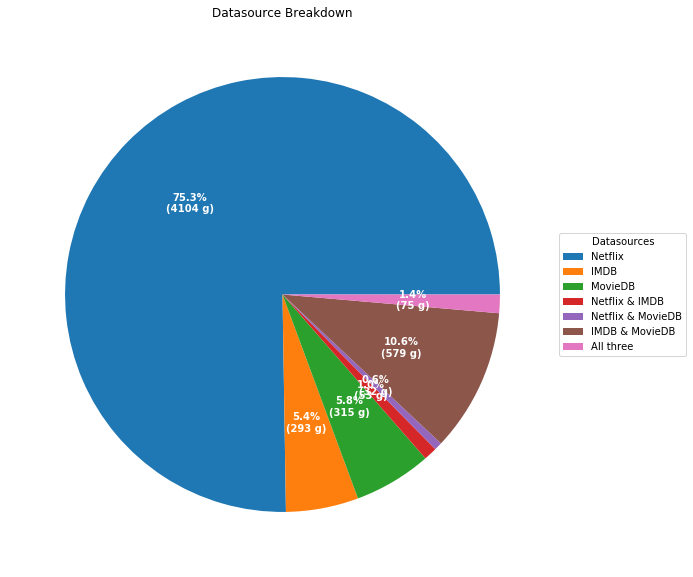

In [9]:
# Something that I would find interesting here is of the movies, what is the overlap
# ie which movies are seen in which sources

# So we first have to build this in our datastructure
full_movies_df["netflix"] = ~full_movies_df.netflix_id.isnull()
full_movies_df["imdb"] = ~full_movies_df.imdb_title.isnull()
full_movies_df["moviedb"] = ~full_movies_df.moviedb_id.isnull()

# Now we look for overlap
full_movies_df["netflix_imdb"] = (full_movies_df.netflix & full_movies_df.imdb)
full_movies_df["netflix_moviedb"] = (full_movies_df.netflix & full_movies_df.moviedb)
full_movies_df["imdb_moviedb"] = (full_movies_df.imdb & full_movies_df.moviedb)
full_movies_df["all_three"] = (full_movies_df.netflix & full_movies_df.imdb & full_movies_df.moviedb)

# Set values that have combined the other values to False for simplicity
full_movies_df.loc[(full_movies_df.netflix_imdb | full_movies_df.netflix_moviedb | full_movies_df.imdb_moviedb | full_movies_df.all_three),"netflix"] = False
full_movies_df.loc[(full_movies_df.netflix_imdb | full_movies_df.netflix_moviedb | full_movies_df.imdb_moviedb | full_movies_df.all_three),"imdb"] = False
full_movies_df.loc[(full_movies_df.netflix_imdb | full_movies_df.netflix_moviedb | full_movies_df.imdb_moviedb | full_movies_df.all_three),"moviedb"] = False
full_movies_df.loc[(full_movies_df.all_three), "netflix_imdb"] = False
full_movies_df.loc[(full_movies_df.all_three), "netflix_moviedb"] = False
full_movies_df.loc[(full_movies_df.all_three), "imdb_moviedb"] = False

# Going to cheat and run boolean vectors to sum, which will give us count of true values
source_sums = [full_movies_df.netflix.sum(), full_movies_df.imdb.sum(), full_movies_df.moviedb.sum(),
               full_movies_df.netflix_imdb.sum(), full_movies_df.netflix_moviedb.sum(), 
               full_movies_df.imdb_moviedb.sum(), full_movies_df.all_three.sum()
              ]
source_names = ["Netflix", "IMDB", "MovieDB", "Netflix & IMDB", "Netflix & MovieDB", "IMDB & MovieDB", "All three"]

# Now for creating the viz
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(aspect="equal"))

def func(pct, allvals):
    absolute = int(pct/100.*np.sum(allvals))
    return "{:.1f}%\n({:d} g)".format(pct, absolute)

wedges, texts, autotexts = ax.pie(source_sums, autopct=lambda pct: func(pct, source_sums),
                                  textprops=dict(color="w"))

ax.legend(wedges, source_names, title="Datasources", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))

plt.setp(autotexts, size=10, weight="bold")

ax.set_title("Datasource Breakdown")

plt.show()

#### IMDB Ranking and Ratings Breakdown

Now I would like to see a ratings breakdown and if they are ranked according to imdb

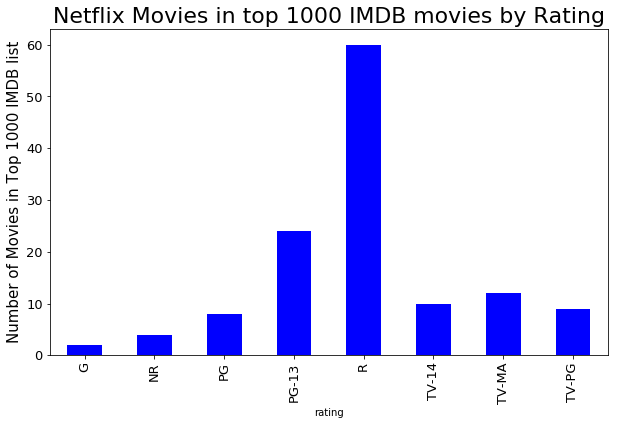

In [10]:
# Here we likely don't need to actually add any new fields and can stay on the fields that we have_
bar_df = full_movies_df[ (full_movies_df.netflix_imdb | full_movies_df.all_three) ].groupby(["rating"]).size()
ax = bar_df.plot(kind='bar', figsize=(10,6), color="blue", fontsize=13);
ax.set_alpha(0.8)
ax.set_title("Netflix Movies in top 1000 IMDB movies by Rating", fontsize=22)
ax.set_ylabel("Number of Movies in Top 1000 IMDB list", fontsize=15);
plt.show()

#### MovieDB Ranking and Ratings Breakdown

Same type of breakdown but I am curious about the ranking according to moviedb


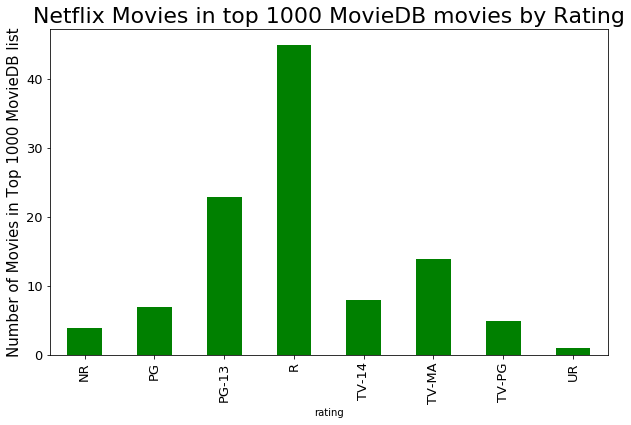

In [11]:
# Here we likely don't need to actually add any new fields and can stay on the fields that we have_
bar_df = full_movies_df[ (full_movies_df.netflix_moviedb | full_movies_df.all_three) ].groupby(["rating"]).size()
ax = bar_df.plot(kind='bar', figsize=(10,6), color="green", fontsize=13);
ax.set_alpha(0.8)
ax.set_title("Netflix Movies in top 1000 MovieDB movies by Rating", fontsize=22)
ax.set_ylabel("Number of Movies in Top 1000 MovieDB list", fontsize=15);
plt.show()

#### Runtime Distribution with Rankings

I want to see the distirubiton of the number of ranked videos according to imdb

Text(0.5,0,'Runtime')

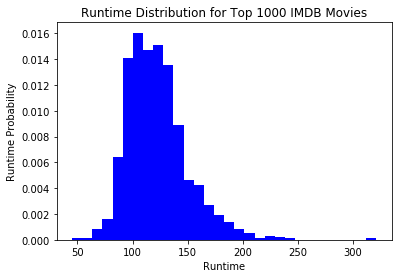

In [12]:
# Creating histogram
plt.hist(full_movies_df[ ~full_movies_df.imdb_title.isnull() ].imdb_runtime, density=True, bins=30, color="blue")
plt.title("Runtime Distribution for Top 1000 IMDB Movies")
plt.ylabel('Runtime Probability')
plt.xlabel('Runtime')

#### Runtime Distribution with Rankings

I want to see the distirubiton of the number of ranked videos according to moviedb

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  


Text(0.5,0,'Runtime')

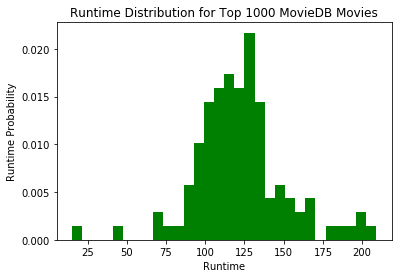

In [13]:
#  Creating histogram for the same view but for movie_db but I hthis time have to get some runtimes mined out
full_movies_df.norm_runtime = full_movies_df.imdb_runtime
full_movies_df.norm_runtime
full_movies_df.loc[ (~full_movies_df.moviedb_id.isnull() & ~full_movies_df.netflix_id.isnull()), "norm_runtime" ] = full_movies_df[ (~full_movies_df.moviedb_id.isnull() & ~full_movies_df.netflix_id.isnull()) ].netflix_timedelta / datetime.timedelta(minutes=1)
# Had to convert to this to a smalle df temporarily so to avoid creating NaN records randomly
tmp_df = full_movies_df[ full_movies_df["norm_runtime"].notnull() ]
plt.hist(tmp_df[ ~tmp_df.moviedb_id.isnull() ].norm_runtime, density=True, bins=30, color="green")
plt.title("Runtime Distribution for Top 1000 MovieDB Movies")
plt.ylabel('Runtime Probability')
plt.xlabel('Runtime')

#### Breakdown of Netflix Movies and their Rankings

I finally want to see from the netflix only data, and the count of movies that were in certain rankings per source

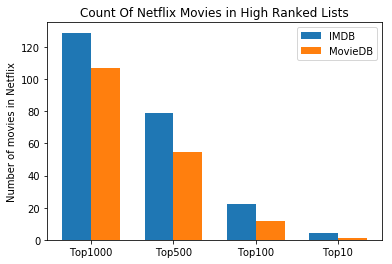

In [14]:
# This will be done in two different ways, but first let's get those records that are found in netflix
tmp_df = full_movies_df[ (~full_movies_df.netflix_id.isnull()) ]
imdb_1000 = len(tmp_df[ (~tmp_df.imdb_ranking.isnull()) ])
imdb_500 = len(tmp_df[ (tmp_df.imdb_ranking<=500)])
imdb_100 = len(tmp_df[ (tmp_df.imdb_ranking<=100)])
imdb_10 = len(tmp_df[ (tmp_df.imdb_ranking<=10)])
moviedb_1000 = len(tmp_df[ (~tmp_df.moviedb_ranking.isnull()) ])
moviedb_500 = len(tmp_df[ (tmp_df.moviedb_ranking<=500) ])
moviedb_100 = len(tmp_df[ (tmp_df.moviedb_ranking<=100) ])
moviedb_10 = len(tmp_df[ (tmp_df.moviedb_ranking<=10) ])

# put them into separate lists
imdb_counts = [imdb_1000, imdb_500, imdb_100, imdb_10]
moviedb_counts = [moviedb_1000, moviedb_500, moviedb_100, moviedb_10]
labels = ["Top1000", "Top500", "Top100", "Top10"]
x = np.arange(len(labels))
width = 0.35

# Building that actual viz
fig, ax = plt.subplots()
imdb_bars = ax.bar(x - width/2, imdb_counts, width, label='IMDB')
moviedb_bars = ax.bar(x + width/2, moviedb_counts, width, label='MovieDB')
ax.set_ylabel('Number of movies in Netflix')
ax.set_title('Count Of Netflix Movies in High Ranked Lists')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
plt.show()